In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from DDPG_Utils import Agent
from matplotlib import pyplot as plt

In [2]:
env = gym.make('Reacher-v4')
agent = Agent(lr_actor=1e-5, lr_critic=5e-4, input_dims=[10], tau=0.001, env=env, n_actions=2, gamma=0.99)

In [3]:
train_episodes = 500
max_steps = 200
score_history = []
for i in range(train_episodes):
    done = False
    score = 0
    step = 0
    s = env.reset()[0]
    s = s[:-1]
    while not done and step < max_steps:
        a = agent.choose_action(s)
        s2, _, done, _, _ = env.step(a)
        s2 = s2[:-1]
        d = np.sqrt(s2[8]**2 + s2[9]**2)
        act = np.abs(a[0]) + np.abs(a[1])
        kin = 0.5*(s2[6]**2 + s2[7]**2)
        r = -0.5*(d/0.42) - 0.1*(act/2) - 0.4*(kin/(2*10**4))
        agent.remember(s, a, r, s2, int(done))
        agent.learn()
        score += r
        s = s2
        step+=1
    score_history.append(score)
    if i == 0 or (i+1) % 20 == 0:
        print(f'[ Episode: {i+1} / {train_episodes} | 20-Episode Average Reward: {np.mean(score_history[-20:]):.2f}')
        T.save(agent.actor.state_dict(), 'ReacherModels/actor.pt')
env.close()

C:\Users\tsami\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[ Episode: 1 / 500 | 20-Episode Average Reward: -65.65
[ Episode: 20 / 500 | 20-Episode Average Reward: -67.26
[ Episode: 40 / 500 | 20-Episode Average Reward: -56.71
[ Episode: 60 / 500 | 20-Episode Average Reward: -46.24
[ Episode: 80 / 500 | 20-Episode Average Reward: -41.52
[ Episode: 100 / 500 | 20-Episode Average Reward: -35.06
[ Episode: 120 / 500 | 20-Episode Average Reward: -41.19
[ Episode: 140 / 500 | 20-Episode Average Reward: -30.55
[ Episode: 160 / 500 | 20-Episode Average Reward: -26.08
[ Episode: 180 / 500 | 20-Episode Average Reward: -20.16
[ Episode: 200 / 500 | 20-Episode Average Reward: -22.42
[ Episode: 220 / 500 | 20-Episode Average Reward: -19.65
[ Episode: 240 / 500 | 20-Episode Average Reward: -20.71
[ Episode: 260 / 500 | 20-Episode Average Reward: -22.79
[ Episode: 280 / 500 | 20-Episode Average Reward: -23.37
[ Episode: 300 / 500 | 20-Episode Average Reward: -17.78
[ Episode: 320 / 500 | 20-Episode Average Reward: -16.97
[ Episode: 340 / 500 | 20-Episode Ave

In [5]:
from scipy.stats import t

running_avg = []
upper_bounds = []
lower_bounds = []
confidence_level = 0.95

for n in range(1, train_episodes):
    current_running_avg = np.mean(score_history[:n])
    running_avg.append(current_running_avg)

    std_dev = np.std(score_history[:n])

    t_value = t.ppf((1 + confidence_level) / 2, n - 1)

    upper_bound = current_running_avg + t_value * std_dev / np.sqrt(n)
    lower_bound = current_running_avg - t_value * std_dev / np.sqrt(n)

    upper_bounds.append(upper_bound)
    lower_bounds.append(lower_bound)

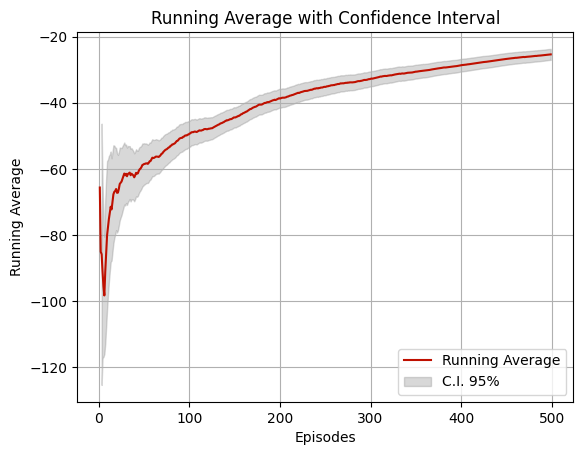

In [16]:
plt.plot(range(1, train_episodes), running_avg, color='#bf1000', label='Running Average')
plt.fill_between(range(3, train_episodes), lower_bounds[2:], upper_bounds[2:], color='gray', alpha=0.3, label='C.I. 95%')
plt.legend(loc='lower right')
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Running Average')
plt.title('Running Average with Confidence Interval')
plt.show()

In [21]:
env = gym.make('Reacher-v4', render_mode='rgb_array')
frames = []
done = False
score = 0
step = 0
s = env.reset()[0]
while not done and step < max_steps:
    frames.append(env.render())
    a = agent.choose_action(s[:-1], with_noise=False)
    s, r, done, _, _ = env.step(a)
    d = np.sqrt(s[8]**2 + s[9]**2)
    act = np.abs(a[0]) + np.abs(a[1])
    kin = 0.5*(s[6]**2 + s[7]**2)
    r = -0.5*(d/0.42) - 0.1*(act/2) - 0.4*(kin/(2*10**4))
    score += r
    step+=1
print(f'Episode Reward: {score:.2f}')
env.close()

Episode Reward: -7.35


In [22]:
from PIL import Image

frames2 = [Image.fromarray(frame) for frame in frames]
last_frame = frames2[-1]
for i in range(30):
    frames2.append(last_frame)
frames2[0].save('Reacher.gif', save_all=True, append_images=frames2[1:], duration=40, loop=0)